# Galaxy10 Pipeline - Visualization & FiftyOne Integration

This notebook creates interactive visualizations and FiftyOne integration:
- **UMAP/t-SNE/PCA**: 2D projections of embeddings
- **FiftyOne App**: Interactive exploration with similarity search
- **CLIP Search**: Text-based queries like 'spiral galaxy with bright core'
- **Persistent Dataset**: Save dataset to open anytime with `fiftyone app launch galaxy10`

## 1. Setup and Imports

In [1]:
import sys
import os
import time
import h5py
import numpy as np
import pandas as pd
import joblib
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import fiftyone as fo
import fiftyone.brain as fob

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.config import DATASET_PATH, N_JOBS, EMBEDDINGS_DIR, MODELS_DIR, CLASS_NAMES

print(f"✓ Imports complete")
print(f"✓ Using {N_JOBS} CPU cores for parallel processing")

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

Configuration loaded: Using 21 CPU cores for parallel processing
✓ Imports complete
✓ Using 21 CPU cores for parallel processing


## 2. Load Dataset and Embeddings

In [2]:
print("="*70)
print("Loading Dataset and Embeddings")
print("="*70)

# Load images and labels
with h5py.File(DATASET_PATH, 'r') as f:
    images = np.array(f['images'])
    labels = np.array(f['ans'])

print(f"\n✓ Loaded {len(images):,} images")
print(f"✓ Image shape: {images.shape}")

# Load embeddings
vit_embeddings = np.load(os.path.join(EMBEDDINGS_DIR, 'vit_embeddings.npy'))
efficientnet_embeddings = np.load(os.path.join(EMBEDDINGS_DIR, 'efficientnet_embeddings.npy'))
clip_embeddings = np.load(os.path.join(EMBEDDINGS_DIR, 'clip_embeddings.npy'))

print(f"\n✓ ViT embeddings: {vit_embeddings.shape}")
print(f"✓ EfficientNet embeddings: {efficientnet_embeddings.shape}")
print(f"✓ CLIP embeddings: {clip_embeddings.shape}")

# Concatenate embeddings
X = np.concatenate([vit_embeddings, efficientnet_embeddings, clip_embeddings], axis=1)
print(f"\n✓ Concatenated embeddings: {X.shape}")

# Load best model and scaler
best_clf = joblib.load(os.path.join(MODELS_DIR, 'best_classifier.pkl'))
scaler = joblib.load(os.path.join(MODELS_DIR, 'scaler.pkl'))
X_scaled = scaler.transform(X)

# Get predictions
y_pred = best_clf.predict(X_scaled)
if hasattr(best_clf, 'predict_proba'):
    y_proba = best_clf.predict_proba(X_scaled)
    confidence = y_proba.max(axis=1)
else:
    confidence = np.ones(len(y_pred))

print(f"\n✓ Generated predictions for all samples")

Loading Dataset and Embeddings

✓ Loaded 17,736 images
✓ Image shape: (17736, 256, 256, 3)

✓ ViT embeddings: (17736, 384)
✓ EfficientNet embeddings: (17736, 1280)
✓ CLIP embeddings: (17736, 512)

✓ Concatenated embeddings: (17736, 2176)

✓ Generated predictions for all samples


## 3. Compute Dimensionality Reduction

In [3]:
def compute_dimensionality_reduction(embeddings, method='umap', n_jobs=N_JOBS):
    print(f"\nComputing {method.upper()} projection...")
    start_time = time.time()
    
    if method == 'umap':
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', n_jobs=n_jobs, random_state=42)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, max_iter=1000, n_jobs=n_jobs, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    coords = reducer.fit_transform(embeddings)
    elapsed = time.time() - start_time
    print(f"✓ {method.upper()} complete in {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
    return coords

print("="*70)
print("Computing Dimensionality Reductions")
print("="*70)

umap_coords = compute_dimensionality_reduction(X_scaled, method='umap')
tsne_coords = compute_dimensionality_reduction(X_scaled, method='tsne')
pca_coords = compute_dimensionality_reduction(X_scaled, method='pca')

print(f"\n✓ All projections computed")

Computing Dimensionality Reductions

Computing UMAP projection...


/home/salix/miniconda3/envs/galaxy10/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ UMAP complete in 21.56 seconds (0.36 minutes)

Computing TSNE projection...
✓ TSNE complete in 35.56 seconds (0.59 minutes)

Computing PCA projection...
✓ PCA complete in 0.28 seconds (0.00 minutes)

✓ All projections computed


## 4. Visualize Projections

Generating Projection Visualizations


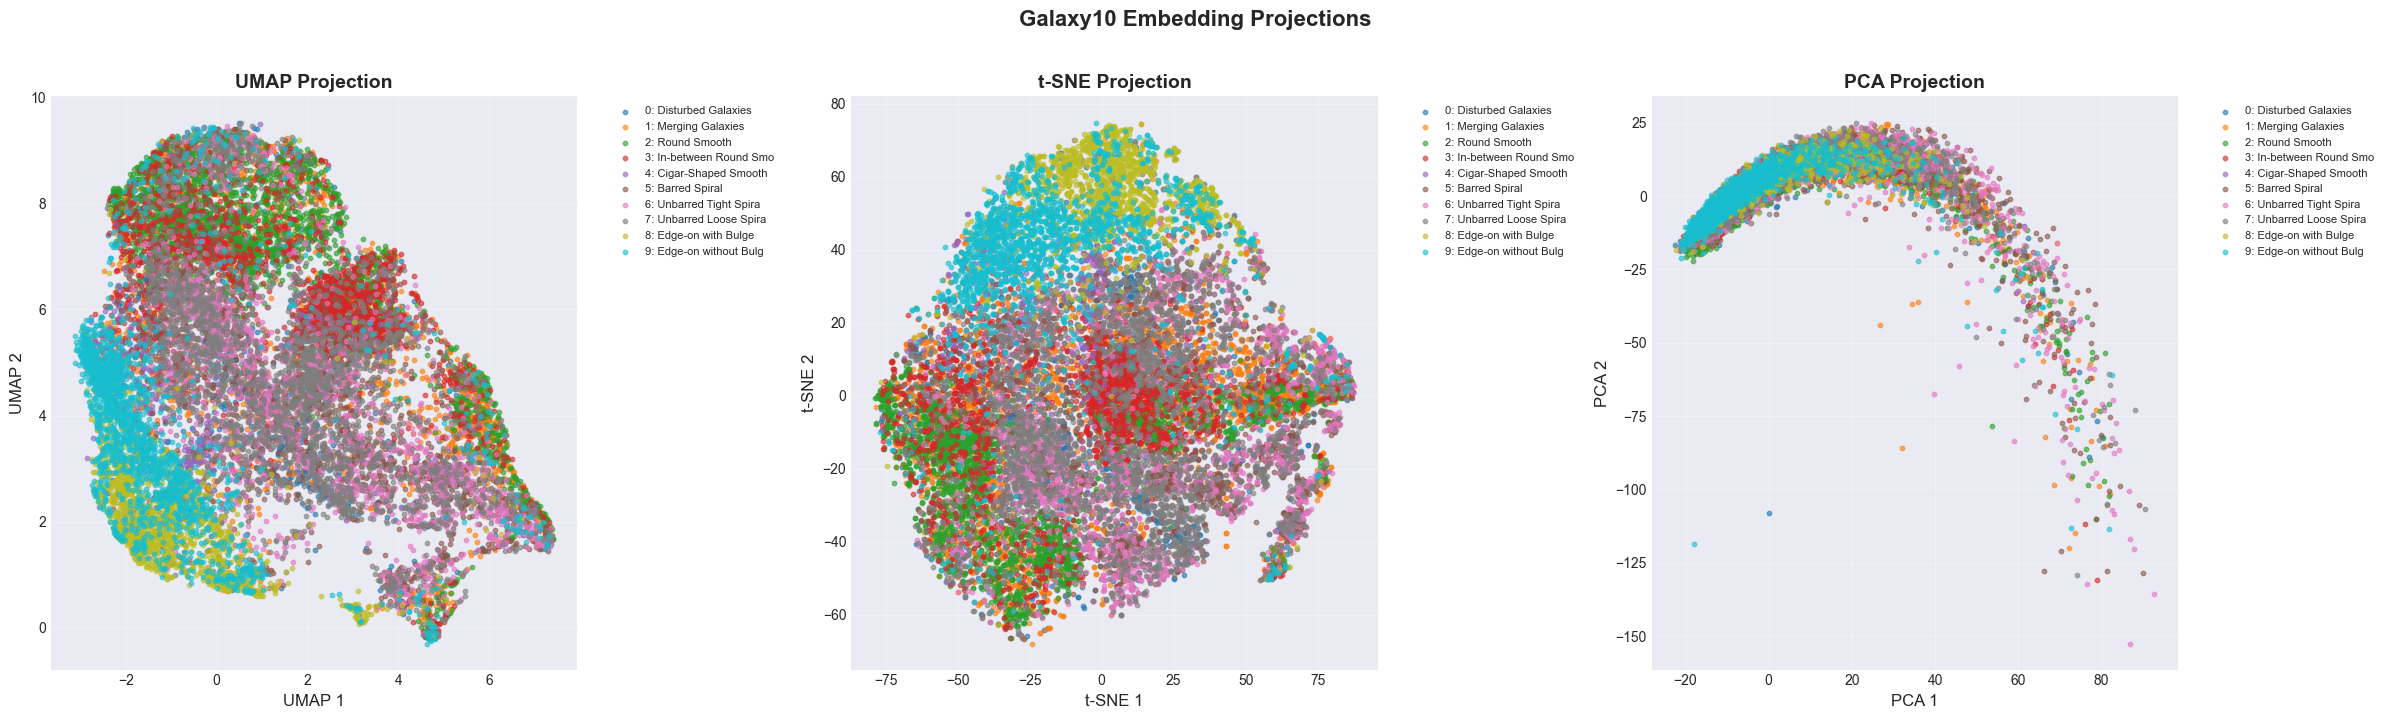


✓ Saved projections to artifacts/visualizations/embedding_projections.png


In [4]:
print("="*70)
print("Generating Projection Visualizations")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(24, 7))
projections = [('UMAP', umap_coords), ('t-SNE', tsne_coords), ('PCA', pca_coords)]
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for ax, (name, coords) in zip(axes, projections):
    for class_id in range(10):
        mask = labels == class_id
        ax.scatter(coords[mask, 0], coords[mask, 1], c=[colors[class_id]], label=f"{class_id}: {CLASS_NAMES[class_id][:20]}", alpha=0.6, s=10)
    ax.set_xlabel(f'{name} 1', fontsize=12)
    ax.set_ylabel(f'{name} 2', fontsize=12)
    ax.set_title(f'{name} Projection', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Galaxy10 Embedding Projections', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../artifacts/visualizations/embedding_projections.png', dpi=600, bbox_inches='tight')
plt.show()
print("\n✓ Saved projections to artifacts/visualizations/embedding_projections.png")

## 5. Create Persistent FiftyOne Dataset

In [6]:
print("="*70)
print("Creating Persistent FiftyOne Dataset")
print("="*70)

# Delete existing dataset if it exists
if "galaxy10" in fo.list_datasets():
    print("\nDeleting existing 'galaxy10' dataset...")
    fo.delete_dataset("galaxy10")

# Create persistent dataset
dataset = fo.Dataset("galaxy10")
dataset.persistent = True

# Create permanent image directory
img_dir = os.path.abspath('../artifacts/galaxy_images')
os.makedirs(img_dir, exist_ok=True)

print(f"\nCreating FiftyOne samples...")
samples = []
for i in range(len(images)):
    # Save image permanently
    img_path = os.path.join(img_dir, f'galaxy_{i:05d}.png')
    if not os.path.exists(img_path):
        img = images[i]
        if img.max() > 1.0:
            img = (img / 255.0 * 255).astype(np.uint8)
        Image.fromarray(img).save(img_path)
    
    sample = fo.Sample(filepath=img_path)
    sample["ground_truth"] = fo.Classification(label=CLASS_NAMES[labels[i]])
    sample["prediction"] = fo.Classification(label=CLASS_NAMES[y_pred[i]], confidence=float(confidence[i]))
    sample["class_id"] = int(labels[i])
    sample["predicted_class_id"] = int(y_pred[i])
    sample["is_correct"] = bool(labels[i] == y_pred[i])
    sample["umap_x"] = float(umap_coords[i, 0])
    sample["umap_y"] = float(umap_coords[i, 1])
    sample["tsne_x"] = float(tsne_coords[i, 0])
    sample["tsne_y"] = float(tsne_coords[i, 1])
    sample["pca_x"] = float(pca_coords[i, 0])
    sample["pca_y"] = float(pca_coords[i, 1])
    samples.append(sample)
    
    if (i + 1) % 1000 == 0:
        print(f"  Processed {i+1:,}/{len(images):,} samples")

dataset.add_samples(samples)
print(f"\n Created persistent FiftyOne dataset with {len(dataset):,} samples")
print(f" Dataset name: 'galaxy10'")
print(f"\n To open this dataset anytime, run:")
print(f"   fiftyone app launch galaxy10")

Creating Persistent FiftyOne Dataset
You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information

Deleting existing 'galaxy10' dataset...

Creating FiftyOne samples...
  Processed 1,000/17,736 samples
  Processed 2,000/17,736 samples
  Processed 3,000/17,736 samples
  Processed 4,000/17,736 samples
  Processed 5,000/17,736 samples
  Processed 6,000/17,736 samples
  Processed 7,000/17,736 samples
  Processed 8,000/17,736 samples
  Processed 9,000/17,736 samples
  Processed 10,000/17,736 samples
  Processed 11,000/17,736 samples
  Processed 12,000/17,736 samples
  Processed 13,000/17,736 samples
  Processed 14,000/17,736 samples
  Processed 15,000/17,736 samples
  Processed 16,000/17,736 samples
  Processed 17,0

In [7]:
fo.list_datasets()

['Galaxy10_DECals_FiftyOne_Brain',
 'galaxy10',
 'galaxy10_fiftyone',
 'galaxy_analysis_project']

In [8]:
dataset = fo.load_dataset("galaxy10")


In [10]:
# 1. Compute default image-level and patch-level visualizations
print("→ Computing base image and ground truth visualizations...")
fob.compute_visualization(dataset, embeddings=clip_embeddings, brain_key="clip_embimg_viz")
fob.compute_visualization(dataset,  brain_key="img_viz")   
print("✓ Base visualizations complete")

→ Computing base image and ground truth visualizations...
Generating visualization...
UMAP( verbose=True)
Fri Oct 31 15:35:24 2025 Construct fuzzy simplicial set
Fri Oct 31 15:35:24 2025 Finding Nearest Neighbors
Fri Oct 31 15:35:24 2025 Building RP forest with 12 trees
Fri Oct 31 15:35:25 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Fri Oct 31 15:35:25 2025 Finished Nearest Neighbor Search
Fri Oct 31 15:35:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Oct 31 15:35:27 2025 Finished embedding
Computing embeddings...
 100% |█████████████| 17736/17736 [1.3m elapsed, 0s remaining, 231.9 samples/s]      
Generating visualization...
UMAP( verbose=True)
Fri Oct 31 15:36:45 2025 Construct fuzzy simplicial set
Fri Oct 31 15:36:45 2025 Finding Nearest Neighbors
Fri Oct 31 15:36:45 2025 Building RP forest with 12 trees
Fri Oct 31 15:36:45 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Fri Oct 31 15:36:46 2025 Finished Nearest Neighbor Search
Fri Oct 31 15:36:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Oct 31 15:36:47 2025 Finished embedding
✓ Base visualizations complete


In [12]:
for method in ["umap", "pca"]:
    print(f"→ Computing {method.upper()} projection...")
    fob.compute_visualization(
        dataset,
        embeddings=clip_embeddings,  # pass array, not field name
        method=method,
        brain_key=f"clip_{method}",
        seed=42,
    )
print("✓ Dimensionality reductions complete")


→ Computing UMAP projection...
Generating visualization...
UMAP(n_jobs=1, random_state=42, verbose=True)
Fri Oct 31 15:39:23 2025 Construct fuzzy simplicial set
Fri Oct 31 15:39:23 2025 Finding Nearest Neighbors
Fri Oct 31 15:39:23 2025 Building RP forest with 12 trees


/home/salix/miniconda3/envs/galaxy10/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fri Oct 31 15:39:24 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Fri Oct 31 15:39:25 2025 Finished Nearest Neighbor Search
Fri Oct 31 15:39:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Oct 31 15:39:31 2025 Finished embedding
→ Computing PCA projection...
Generating visualization...
✓ Dimensionality reductions complete


## 6. Add CLIP Similarity Search

In [13]:
print("="*70)
print("Adding CLIP Similarity Search")
print("="*70)

print("\nComputing CLIP similarity index...")
fob.compute_similarity(dataset, model="clip-vit-base32-torch", brain_key="clip_similarity")

print("\n CLIP similarity search enabled")
print("\n Usage examples in FiftyOne app:")
print("  • Search for 'spiral galaxy with bright core'")
print("  • Search for 'elliptical galaxy'")
print("  • Search for 'edge-on disk galaxy'")

Adding CLIP Similarity Search

Computing CLIP similarity index...
Computing embeddings...
 100% |█████████████| 17736/17736 [1.9m elapsed, 0s remaining, 144.5 samples/s]      

 CLIP similarity search enabled

 Usage examples in FiftyOne app:
  • Search for 'spiral galaxy with bright core'
  • Search for 'elliptical galaxy'
  • Search for 'edge-on disk galaxy'


## Classification

In [14]:
results = dataset.evaluate_classifications(
    pred_field="prediction",
    gt_field="ground_truth",
    eval_key="eval",
)

## 7. Launch FiftyOne App

In [16]:
print("="*70)
print("Launching FiftyOne App")
print("="*70)
  
  
session = fo.launch_app(dataset)

print("\n✓ FiftyOne app launched!")
print("\n Features available:")
print("  • Filter by class, prediction, confidence")
print("  • Similarity search (select sample, click 'Sort by similarity')")
print("  • Text search with CLIP")
print("  • View UMAP/PCA coordinates")
print("  • Compare ground truth vs predictions")
print("  • Identify misclassifications (filter by is_correct=False)")
print("\n To close: session.close()")
print(" To reopen anytime: fiftyone app launch galaxy10")

Launching FiftyOne App



✓ FiftyOne app launched!

🎯 Features available:
  • Filter by class, prediction, confidence
  • Similarity search (select sample, click 'Sort by similarity')
  • Text search with CLIP
  • View UMAP/PCA coordinates
  • Compare ground truth vs predictions
  • Identify misclassifications (filter by is_correct=False)

💡 To close: session.close()
💡 To reopen anytime: fiftyone app launch galaxy10


## 8. Analyze Misclassifications

Analyzing Misclassifications

✓ Found 61 misclassified samples (0.34%)

 Top 10 Confusion Patterns:
  • Disturbed Galaxies        → Unbarred Loose Spiral    :   11 samples
  • Unbarred Loose Spiral     → Disturbed Galaxies       :    8 samples
  • Disturbed Galaxies        → In-between Round Smooth  :    6 samples
  • Unbarred Loose Spiral     → Merging Galaxies         :    6 samples
  • Disturbed Galaxies        → Round Smooth             :    4 samples
  • Unbarred Loose Spiral     → Edge-on without Bulge    :    4 samples
  • Round Smooth              → Unbarred Tight Spiral    :    3 samples
  • Merging Galaxies          → Unbarred Loose Spiral    :    2 samples
  • Unbarred Tight Spiral     → Round Smooth             :    2 samples
  • Edge-on without Bulge     → Unbarred Tight Spiral    :    2 samples


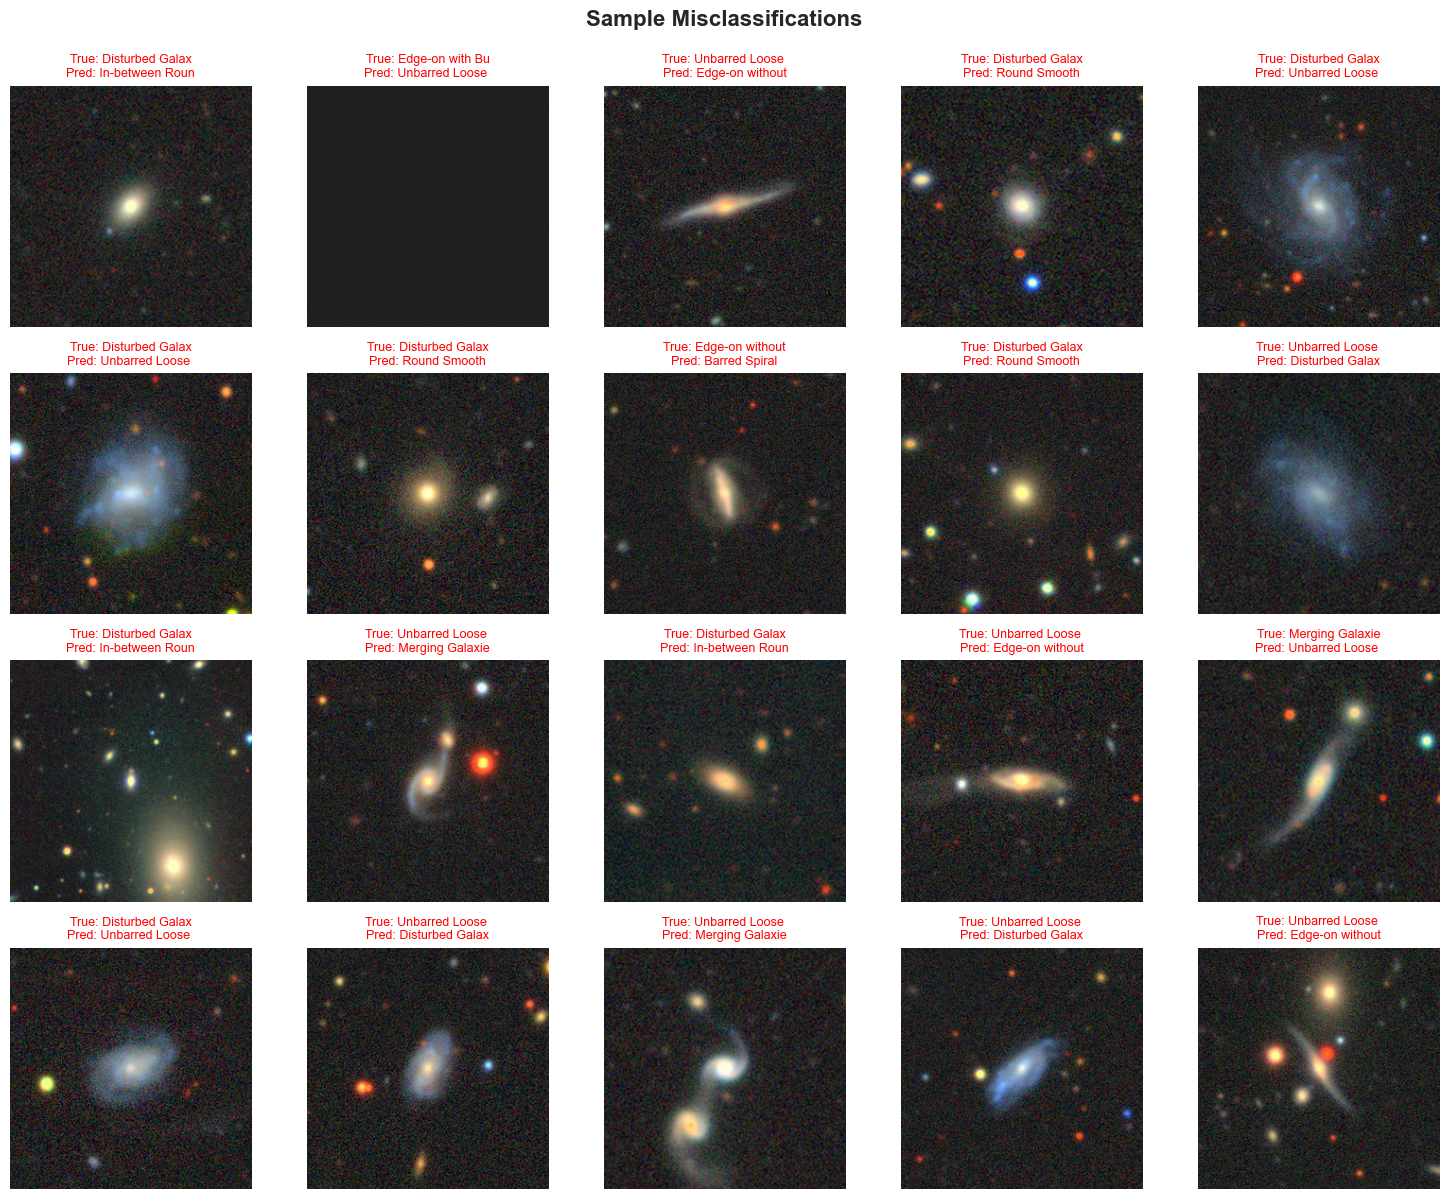


✓ Saved to artifacts/visualizations/misclassifications.png


In [17]:
print("="*70)
print("Analyzing Misclassifications")
print("="*70)

misclassified_mask = labels != y_pred
misclassified_indices = np.where(misclassified_mask)[0]
print(f"\n✓ Found {len(misclassified_indices):,} misclassified samples ({len(misclassified_indices)/len(labels)*100:.2f}%)")

# Analyze confusion patterns
confusion_pairs = {}
for idx in misclassified_indices:
    pair = (labels[idx], y_pred[idx])
    confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

top_confusions = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\n Top 10 Confusion Patterns:")
for (true_label, pred_label), count in top_confusions:
    print(f"  • {CLASS_NAMES[true_label][:25]:25s} → {CLASS_NAMES[pred_label][:25]:25s}: {count:4d} samples")

# Visualize sample misclassifications
sample_indices = np.random.choice(misclassified_indices, size=min(20, len(misclassified_indices)), replace=False)
n_cols = 5
n_rows = (len(sample_indices) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for i, idx in enumerate(sample_indices):
    ax = axes[i]
    img = images[idx]
    if img.max() > 1.0:
        img = img / 255.0
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {CLASS_NAMES[labels[idx]][:15]}\nPred: {CLASS_NAMES[y_pred[idx]][:15]}", fontsize=9, color='red')

for i in range(len(sample_indices), len(axes)):
    axes[i].axis('off')

plt.suptitle('Sample Misclassifications', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../artifacts/visualizations/misclassifications.png', dpi=600, bbox_inches='tight')
plt.show()
print("\n✓ Saved to artifacts/visualizations/misclassifications.png")

## 9. Per-Class Performance

Computing Per-Class Metrics

📊 Per-Class Metrics:
                  Class Precision Recall F1-Score  Support
     Disturbed Galaxies    0.9925 0.9796   0.9860     1081
       Merging Galaxies    0.9946 0.9978   0.9962     1853
           Round Smooth    0.9977 0.9985   0.9981     2645
In-between Round Smooth    0.9970 1.0000   0.9985     2027
    Cigar-Shaped Smooth    1.0000 0.9970   0.9985      334
          Barred Spiral    0.9980 0.9995   0.9988     2043
  Unbarred Tight Spiral    0.9962 0.9984   0.9973     1829
  Unbarred Loose Spiral    0.9943 0.9928   0.9935     2628
     Edge-on with Bulge    0.9993 0.9979   0.9986     1423
  Edge-on without Bulge    0.9979 0.9979   0.9979     1873

✓ Saved to ../artifacts/visualizations/per_class_metrics_viz.csv


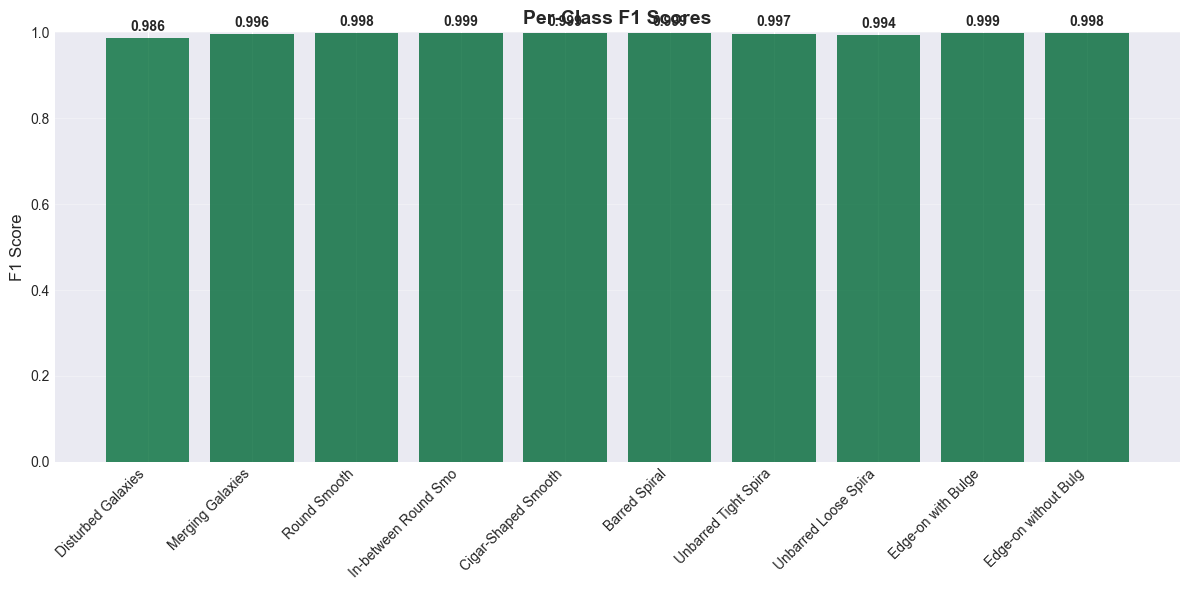


✓ Saved to artifacts/visualizations/per_class_f1_scores.png


In [21]:
from sklearn.metrics import precision_recall_fscore_support

print("="*70)
print("Computing Per-Class Metrics")
print("="*70)

precision, recall, f1, support = precision_recall_fscore_support(labels, y_pred, average=None)

metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': [f"{p:.4f}" for p in precision],
    'Recall': [f"{r:.4f}" for r in recall],
    'F1-Score': [f"{f:.4f}" for f in f1],
    'Support': support
})

print("\n📊 Per-Class Metrics:")
print(metrics_df.to_string(index=False))

metrics_path = '../artifacts/visualizations/per_class_metrics_viz.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✓ Saved to {metrics_path}")

# Visualize F1 scores
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.RdYlGn(f1)
bars = ax.bar(range(len(CLASS_NAMES)), f1, color=colors, alpha=0.8)
ax.set_xticks(range(len(CLASS_NAMES)))
ax.set_xticklabels([name[:20] for name in CLASS_NAMES], rotation=45, ha='right')
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Per-Class F1 Scores', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, f1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../artifacts/visualizations/per_class_f1_scores.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved to artifacts/visualizations/per_class_f1_scores.png")

## 10. Summary Report

In [42]:
print("="*70)
print("📊 VISUALIZATION & FIFTYONE INTEGRATION SUMMARY")
print("="*70)

print(f"\n✓ Processed {len(images):,} galaxy images")
print(f"\n📈 Dimensionality Reductions:")
print(f"  • UMAP: {umap_coords.shape}")
print(f"  • PCA: {pca_coords.shape}")

print(f"\n🎯 FiftyOne Dataset:")
print(f"  • Name: 'galaxy10' (persistent)")
print(f"  • Total samples: {len(dataset):,}")
print(f"  • CLIP similarity: Enabled")
print(f"  • Image directory: {img_dir}")

print(f"\n📊 Classification Performance:")
print(f"  • Correct: {(labels == y_pred).sum():,} ({(labels == y_pred).sum()/len(labels)*100:.2f}%)")
print(f"  • Misclassified: {len(misclassified_indices):,} ({len(misclassified_indices)/len(labels)*100:.2f}%)")

print(f"\n💾 Generated Artifacts:")
print(f"  • artifacts/visualizations/embedding_projections.png")
print(f"  • artifacts/visualizations/misclassifications.png")
print(f"  • artifacts/visualizations/per_class_f1_scores.png")
print(f"  • artifacts/visualizations/per_class_metrics_viz.csv")

print(f"\n🎯 How to Use FiftyOne Dataset:")
print(f"  1. From terminal: fiftyone app launch galaxy10")
print(f"  2. From Python: session = fo.launch_app(fo.load_dataset('galaxy10'))")
print(f"  3. Filter misclassifications: is_correct=False")
print(f"  4. Text search: Use CLIP similarity")
print(f"  5. Visual search: Select sample → Sort by similarity")

print("\n" + "="*70)
print("✅ Visualization complete! FiftyOne dataset saved permanently.")
print("="*70)

📊 VISUALIZATION & FIFTYONE INTEGRATION SUMMARY

✓ Processed 17,736 galaxy images

📈 Dimensionality Reductions:
  • UMAP: (17736, 2)
  • PCA: (17736, 2)

🎯 FiftyOne Dataset:
  • Name: 'galaxy10' (persistent)
  • Total samples: 17,736
  • CLIP similarity: Enabled
  • Image directory: /home/salix/Documents/galaxy10/artifacts/galaxy_images

📊 Classification Performance:
  • Correct: 17,675 (99.66%)
  • Misclassified: 61 (0.34%)

💾 Generated Artifacts:
  • artifacts/visualizations/embedding_projections.png
  • artifacts/visualizations/misclassifications.png
  • artifacts/visualizations/per_class_f1_scores.png
  • artifacts/visualizations/per_class_metrics_viz.csv

🎯 How to Use FiftyOne Dataset:
  1. From terminal: fiftyone app launch galaxy10
  2. From Python: session = fo.launch_app(fo.load_dataset('galaxy10'))
  3. Filter misclassifications: is_correct=False
  4. Text search: Use CLIP similarity
  5. Visual search: Select sample → Sort by similarity

✅ Visualization complete! FiftyOne dat


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



## 📚 FiftyOne, FiftyOne Brain & CLIP Resources

### 🧠 FiftyOne (Core)
- **Documentation:** [FiftyOne User Guide](https://docs.voxel51.com/user_guide/index.html) — explore datasets, visualizations, and App features.  
- **GitHub:** [voxel51/fiftyone](https://github.com/voxel51/fiftyone)  
- **PyPI:** [fiftyone](https://pypi.org/project/fiftyone/)  
- **Video:** [FiftyOne Computer Vision Tips & Tricks (YouTube)](https://www.youtube.com/watch?v=hVHPWN4vOn8)

**Key Features**
- Interactive dataset visualization
- Embeddings and similarity search
- Model evaluation and confusion matrices
- Tight integration with TensorFlow, PyTorch, and Hugging Face

---

### 🧩 FiftyOne Brain
- **Documentation:** [FiftyOne Brain Overview](https://docs.voxel51.com/brain.html) — learn about uniqueness, similarity, and error analysis.  
- **GitHub:** [voxel51/fiftyone-brain](https://github.com/voxel51/fiftyone-brain)  
- **PyPI:** [fiftyone-brain](https://pypi.org/project/fiftyone-brain/)  
- **Tutorial:** [Exploring Image Uniqueness with FiftyOne](https://docs.voxel51.com/tutorials/uniqueness.html)  
- **Video:** [Find Your Most Similar Samples with FiftyOne Brain (YouTube)](https://www.youtube.com/watch?v=Znc_M6IZegw)

**Useful Functions**
- `fob.compute_visualization()` — generate embeddings visualizations  
- `fob.compute_similarity()` — compute similarity matrices  
- `fob.compute_uniqueness()` — measure dataset diversity  

---

### 🎯 CLIP + FiftyOne Integration
- **Docs:** [Visualization API Reference](https://docs.voxel51.com/api/fiftyone.brain.visualization.html)  
- **GitHub:** [voxel51/openai-clip](https://github.com/voxel51/openai-clip)

**Applications**
- Zero-shot labeling and retrieval  
- Embedding-based search  
- Multimodal analysis (image ↔ text)

---

### 🔗 Quick Reference Table

| Tool             | Documentation | GitHub Repository | Video / Tutorial |
|------------------|---------------|------------------|------------------|
| **FiftyOne**     | [docs.voxel51.com/user_guide](https://docs.voxel51.com/user_guide) | [voxel51/fiftyone](https://github.com/voxel51/fiftyone) | [Tips & Tricks](https://www.youtube.com/watch?v=hVHPWN4vOn8) |
| **FiftyOne Brain** | [docs.voxel51.com/brain](https://docs.voxel51.com/brain.html) | [voxel51/fiftyone-brain](https://github.com/voxel51/fiftyone-brain) | [Similarity Search](https://www.youtube.com/watch?v=Znc_M6IZegw) |
| **CLIP Integration** | [API Reference](https://docs.voxel51.com/api/fiftyone.brain.visualization.html) | [voxel51/openai-clip](https://github.com/voxel51/openai-clip) | — |

---

### 🎥 Recommended Learning Resources
- [FiftyOne YouTube Channel](https://www.youtube.com/@voxel51) — official tutorials and walkthroughs  
- [Introduction to FiftyOne (Short Course)](https://learn.voxel51.com/courses/fiftyone) — interactive visual learning  
- [FiftyOne Community Slack](https://join.slack.com/t/voxel51/shared_invite/zt-fpds5az3-WjvwZVvcwRMWtDwhT7Rz2g) — connect with CV engineers and researchers  

---

> 💡 **Tip:** You can launch the FiftyOne App anytime using:
> ```python
> import fiftyone as fo
> session = fo.launch_app(dataset)
> ```
> Then close it with:
> ```python
> session.close()
> ```
